# **Classification**

In the classification section of this project, the best classification models for each dataset (DataAP, dataPHY and dataALL) will be assessed and evaluated.

We import the pandas and numpy libraries:

In [802]:
import pandas as pd
import numpy as np

for the visual analysis we import the following libraries:


In [803]:
import seaborn as sns 
from matplotlib import pyplot as plt
%matplotlib inline

## Importing the preprocessed data

We import the dataframes:

In [804]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing the dataframes dataAP and dataPHY:

- dataAP: data containing the original variables that best correlate with the label data of the dataframe.

- dataPHY: data containing variables from the blood test that are of interest.

- dataALL: Both dataAP and dataPHY combined

In [805]:
#Importing dataAP
file_name = '/content/drive/MyDrive/TFG/dataAP.csv'
dataAP = pd.read_csv(file_name, index_col=[0])

In [806]:
#Importing dataPHY
file_name = '/content/drive/MyDrive/TFG/dataPHY.csv'
dataPHY = pd.read_csv(file_name, index_col=[0])

In [807]:
#Importing dataALL
file_name = '/content/drive/MyDrive/TFG/dataALL.csv'
dataALL = pd.read_csv(file_name, index_col=[0])

One dataframe (**dataAP_g**) will contain the label data in continuous form (Masa_VAT_g) and the other (**dataAP_cat**) will contain the label in
categorical form (Masa_VAT_cat), as stated in the "*Transorming the label data into categotical data*" section from the preprocessing. This is done to avoid confusion when selecting the target variable (Masa_VAT_cat).

Also the label Vol_VAT will be removed as it is technically the same as Masa_VAT.

In [808]:
#Creating a dataAP dataframe only with Masa_VAT_g and another one with only Masa_VAT_cat

dataAP_g = dataAP.copy()
dataAP_cat = dataAP.copy()

dropcat = ["Masa_VAT_g", "Vol_VAT"]
dropg = ["Masa_VAT_cat", "Vol_VAT"]
dataAP_g = dataAP_g.drop(dropg, axis=1)
dataAP_cat = dataAP_cat.drop(dropcat , axis=1)

## **DataAP** 

### Using Grid Search to find the best model and hyper parameter tuning

The models whose best hyperparameters we want to find are the following:
- Logistic Regression
- K-Nearest Neighbours
- Support Vector Machines
- Naïve Bayes
- Decision Tree Classification
- Random Forest Classification

First we define each model and their corresponding possible parameters:

In [809]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier


#Define a simple Python dictionary and let's try the models stated before. (LR, KNn, SVM, Kernel SVM, NB, DTC, RFC)

model_params = {
     'logistic_regression' : {
         'model': LogisticRegression(),
         'params': {
             'solver': ['liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
             'C': [1,5,10,20],
             'penalty' : ['l1', 'l2', 'elasticnet'],
         }
     },
     'Knn': {
        'model': KNeighborsClassifier(),
        'params' : {
            'n_neighbors': [5,10,20,50],
            'weights' : ['uniform', 'distance'],
            'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],

        }
    },
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [5,10,20],
            'kernel': ['rbf','linear'],
        }
    },
    
    'Naive_Bayes': {
        'model': GaussianNB(),
        'params' : {
            'var_smoothing' : [1e-09,1e-12,1e-06],
            
        }
    },
    
    'Decision_tree': {
        'model': DecisionTreeClassifier(),
        'params' : {
            'criterion' : ['gini', 'entropy', 'log_loss'],
            'max_depth' : [0.5,3,4,5,15,20],

        }
    },
     'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'criterion' : ['gini', 'entropy', 'log_loss'],
            'n_estimators': [1,5,10],
        }
    }
}

Next we will evaluate these models using GridSearchCV from Sklearn to find the score of each of the models and their best combinations for their parameters.

First we evaluate with the dataframe DataAP,  that contains features found in the original raw dataframe.

In [810]:
target = dataAP_cat["Masa_VAT_cat"]
data_target = dataAP_cat.copy()
data_target = data_target.drop("Masa_VAT_cat", axis=1)
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore") 

scores = []

#The following for loop is doing nothing but going throught the dictionary previously defined and for each of the value in the dictionary it will apply the GridSearchCV
for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(data_target, target)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,logistic_regression,0.622529,"{'C': 20, 'penalty': 'l1', 'solver': 'saga'}"
1,Knn,0.501149,"{'algorithm': 'auto', 'n_neighbors': 50, 'weig..."
2,svm,0.615862,"{'C': 10, 'kernel': 'linear'}"
3,Naive_Bayes,0.481149,{'var_smoothing': 1e-09}
4,Decision_tree,0.479770,"{'criterion': 'log_loss', 'max_depth': 3}"
5,random_forest,0.493333,"{'criterion': 'entropy', 'n_estimators': 5}"


The best results are from the following models:
- Logistic regression classifier 
- Support Vector machine classifier
- Knn classifier

To choose one of these models first we have to validate them.

In [811]:
#FIRST
#We divide the data between train and testing data:

from sklearn import datasets, linear_model

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
X = dataAP_cat.drop(target, axis=1).values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

AUTOMATIC WAY TO MEASURE ACCURACIES:

In [812]:
#BEST MODELS ACCURACY
import warnings
warnings.filterwarnings("ignore") 

#Accuracy score of decision tree classifier, we import accuracy_score from sklearn
from sklearn.metrics import accuracy_score

# Defining the models with the best parameters found with Grid Search.
LR = LogisticRegression(solver='saga', C=20, penalty='l1')
SVM = svm.SVC(gamma='auto', C=10, kernel='linear')
KNN = KNeighborsClassifier(algorithm='auto', n_neighbors=50, weights='uniform')

models = [LR, SVM, KNN]
accuracy = {'model': [], 'Accuracy': []}
df = pd.DataFrame(accuracy)

for model in models:
  clf = model.fit(X_train, y_train)
  yhat_test = clf.predict(X_test)
  acc = accuracy_score(y_test, yhat_test)
  df = df.append({'model': str(model), 'Accuracy': acc}, ignore_index=True)

print(df)
df

                                               model  Accuracy
0  LogisticRegression(C=20, penalty='l1', solver=...  0.600000
1           SVC(C=10, gamma='auto', kernel='linear')  0.600000
2               KNeighborsClassifier(n_neighbors=50)  0.533333


,model,Accuracy
0,"LogisticRegression(C=20, penalty='l1', solver=...",0.600000
1,"SVC(C=10, gamma='auto', kernel='linear')",0.600000
2,KNeighborsClassifier(n_neighbors=50),0.533333


As we can see LR and SVM have similar accuracies.

###Logistic regression

We define the model:

In [813]:
#FIRST
#We divide the data between train and testing data:

from sklearn.feature_selection import SelectFwe, chi2
from sklearn import datasets, linear_model
from sklearn.feature_selection import SelectPercentile, chi2

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
X = dataAP_cat.drop(target, axis=1).values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(solver='saga', C=20, penalty='l1')
#RandomForestClassifier(SelectFwe(SelectPercentile("input_matrix", percentile=73), alpha=0.025), bootstrap=True, criterion="entropy", max_features=0.3, min_samples_leaf=4, min_samples_split=17, n_estimators=100)
# 
clf = clf.fit(X_train,y_train.ravel())

##### **Mean ROC curve**

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


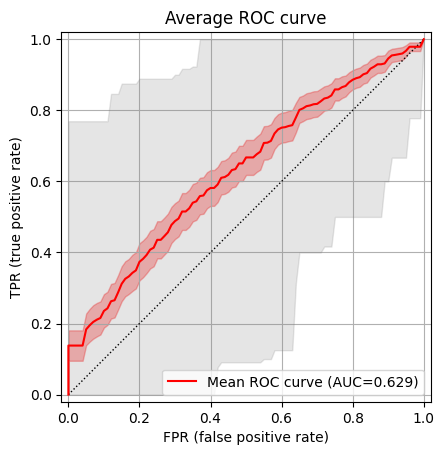

In [814]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.utils import resample
!pip3 install roc_utils
import roc_utils as ru
import warnings
warnings.filterwarnings("ignore") 

# Generating 100 models and predicting 100 test sets using bootstrapping:
rocs = []
n_iterations = 100
for i in range(n_iterations):
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify = y, random_state=i)

    # Scaling the data
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Resampling
    Xtr_bs, ytr_bs = resample(X_train_scaled, y_train, replace=True, random_state=i) 
    Xts_bs, yts_bs = resample(X_test_scaled, y_test, replace=True, random_state=i) 
    
    # Asjusting the model to a training dataset
    model = LogisticRegression(solver='saga', C=20, penalty='l1')
    model.fit(Xtr_bs, ytr_bs) 
    
    # Predictions
    y_hat = model.predict(Xts_bs)
    
    # Model evaluation ROC plots
    y_prob = model.predict_proba(Xts_bs)
    roc = ru.compute_roc(X=y_prob[:,1], y=yts_bs, pos_label=True)
    rocs.append(roc)
       

ru.plot_mean_roc(rocs, show_ci=True)
plt.title("Average ROC curve");

#####Confusion matrix

Text(0.5, 427.9555555555555, 'Predicted label')

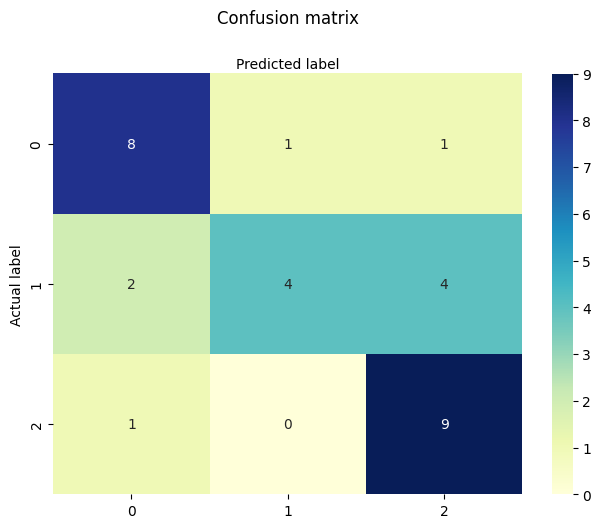

In [815]:
#Testing Logistic regression
Lregr = LogisticRegression(solver='saga', C=20, penalty='l1')

# fit the model with data
Lregr.fit(X_train, y_train)
y_pred = Lregr.predict(X_test)

# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Training and testing error:

In [816]:
model = LogisticRegression(solver='saga', C=20, penalty='l1')
import warnings
warnings.filterwarnings("ignore") 

# create and train your model
model.fit(X_train, y_train)

# make predictions on the training set
y_train_pred = model.predict(X_train)

# calculate the mean squared error of the training set predictions
from sklearn.metrics import mean_squared_error
train_error = mean_squared_error(y_train, y_train_pred)

# make predictions on the testing set
y_test_pred = model.predict(X_test)

# calculate the mean squared error of the testing set predictions
test_error = mean_squared_error(y_test, y_test_pred)

# print out the training and testing errors
print("Training Error: ", train_error)
print("Testing Error: ", test_error)

Training Error:  0.5847457627118644
Testing Error:  0.5


##### **Evaluation metrics using K-cross validation**

Next we have the evaluation metrics of one train-test split:

In [817]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore") 

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
X = dataAP_cat.drop(target, axis=1).values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your model
model =LogisticRegression(solver='saga', C = 20, penalty = 'l1')
model = model.fit(X_train,y_train)

# Make predictions on the test data
predicted_labels = model.predict(X_test)

# EVALUATION METRICS

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)

# Calculate precision
precision = precision_score(y_test, predicted_labels, average='macro')

# Calculate recall
recall = recall_score(y_test, predicted_labels, average='macro')

# Calculate F1-score
f1 = f1_score(y_test, predicted_labels, average='macro')

# Print the evaluation metrics
print("The evaluation metrics of", model, "are:")
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)


The evaluation metrics of LogisticRegression(C=20, penalty='l1', solver='saga') are:
Accuracy: 0.6
Precision: 0.6288515406162465
Recall: 0.6151515151515151
F1-score: 0.577991452991453


**Here we have the evaluation metrics using k-cross validation**

In [818]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore") 

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
X = dataAP_cat.drop(target, axis=1).values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your model
model =LogisticRegression(solver='saga', C = 20, penalty = 'l1')
model = model.fit(X_train,y_train)

# Initialize the k-fold cross-validation object
k = 10  # Define the number of folds
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store the evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test data
    predicted_labels = model.predict(X_test)

    # Calculate evaluation metrics for the current fold
    accuracy_scores.append(accuracy_score(y_test, predicted_labels))
    precision_scores.append(precision_score(y_test, predicted_labels, average='macro'))
    recall_scores.append(recall_score(y_test, predicted_labels, average='macro'))
    f1_scores.append(f1_score(y_test, predicted_labels, average='macro'))

# Print the average evaluation metrics
print("The average evaluation metrics are:")
print('Accuracy:', sum(accuracy_scores) / k)
print('Precision:', sum(precision_scores) / k)
print('Recall:', sum(recall_scores) / k)
print('F1-score:', sum(f1_scores) / k)

The average evaluation metrics are:
Accuracy: 0.589047619047619
Precision: 0.6232539682539683
Recall: 0.5888888888888888
F1-score: 0.5728319828319828


###Support Vector Machine

We define the model:

In [819]:
#FIRST
#We divide the data between train and testing data:

from sklearn.feature_selection import SelectFwe, chi2
from sklearn import datasets, linear_model
from sklearn.feature_selection import SelectPercentile, chi2

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
X = dataAP_cat.drop(target, axis=1).values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = svm.SVC(gamma='auto', C=10, kernel='linear')
clf = clf.fit(X_train,y_train.ravel())

##### **Mean ROC curve**

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


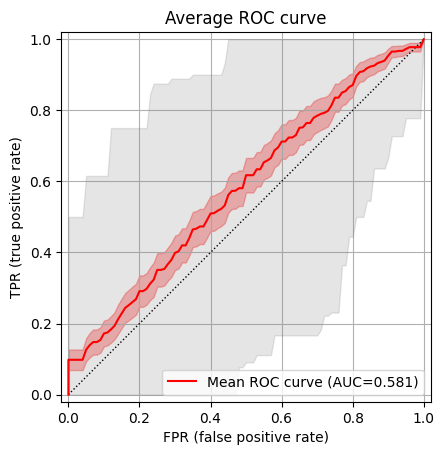

In [820]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.utils import resample
!pip3 install roc_utils
import roc_utils as ru
import warnings
warnings.filterwarnings("ignore") 

# Generating 100 models and predicting 100 test sets using bootstrapping:
rocs = []
n_iterations = 100
for i in range(n_iterations):
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify = y, random_state=i)

    # Scaling the data
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Resampling
    Xtr_bs, ytr_bs = resample(X_train_scaled, y_train, replace=True, random_state=i) 
    Xts_bs, yts_bs = resample(X_test_scaled, y_test, replace=True, random_state=i) 
    
    # Asjusting the model to a training dataset
    model =  svm.SVC(gamma='auto', C=10, kernel='linear', probability =True)
    model.fit(Xtr_bs, ytr_bs) 
    
    # Predictions
    y_hat = model.predict(Xts_bs)
    
    # Model evaluation ROC plots
    y_prob = model.predict_proba(Xts_bs)
    roc = ru.compute_roc(X=y_prob[:,1], y=yts_bs, pos_label=True)
    rocs.append(roc)
       

ru.plot_mean_roc(rocs, show_ci=True)
plt.title("Average ROC curve");

#####Confusion matrix

Text(0.5, 427.9555555555555, 'Predicted label')

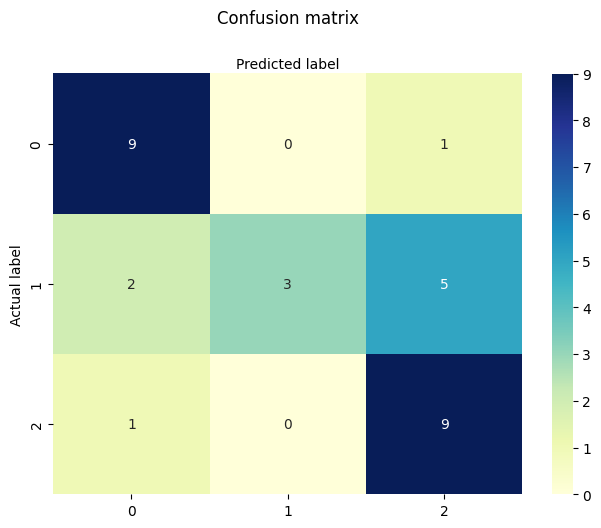

In [821]:
#Testing SVM
model = svm.SVC(gamma='auto', C=10, kernel='linear')

# fit the model with data
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

This model seems to be good to not wrongly predict low values as high ones.

Training and testing error:

In [822]:
model = svm.SVC(gamma='auto', C=10, kernel='linear')
import warnings
warnings.filterwarnings("ignore") 

# create and train your model

model.fit(X_train, y_train)

# make predictions on the training set
y_train_pred = model.predict(X_train)

# calculate the mean squared error of the training set predictions
train_error = mean_squared_error(y_train, y_train_pred)

# make predictions on the testing set
y_test_pred = model.predict(X_test)

# calculate the mean squared error of the testing set predictions
test_error = mean_squared_error(y_test, y_test_pred)

# print out the training and testing errors
print("Training Error: ", train_error)
print("Testing Error: ", test_error)

Training Error:  0.5847457627118644
Testing Error:  0.5


##### **Evaluation metrics using K-cross validation**

Next we have the evaluation metrics of one train-test split:

In [823]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore") 

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
X = dataAP_cat.drop(target, axis=1).values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your model
model = svm.SVC(gamma='auto', C=10, kernel='linear')
model = model.fit(X_train,y_train)

# Make predictions on the test data
predicted_labels = model.predict(X_test)

# EVALUATION METRICS

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)

# Calculate precision
precision = precision_score(y_test, predicted_labels, average='macro')

# Calculate recall
recall = recall_score(y_test, predicted_labels, average='macro')

# Calculate F1-score
f1 = f1_score(y_test, predicted_labels, average='macro')

# Print the evaluation metrics
print("The evaluation metrics of", model, "are:")
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)


The evaluation metrics of SVC(C=10, gamma='auto', kernel='linear') are:
Accuracy: 0.6
Precision: 0.676470588235294
Recall: 0.6181818181818182
F1-score: 0.5872507122507122


**Here we have the evaluation metrics using k-cross validation**

In [824]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore") 

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
X = dataAP_cat.drop(target, axis=1).values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your model
model = svm.SVC(gamma='auto', C=10, kernel='linear')
model = model.fit(X_train,y_train)

# Initialize the k-fold cross-validation object
k = 10  # Define the number of folds
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store the evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test data
    predicted_labels = model.predict(X_test)

    # Calculate evaluation metrics for the current fold
    accuracy_scores.append(accuracy_score(y_test, predicted_labels))
    precision_scores.append(precision_score(y_test, predicted_labels, average='macro'))
    recall_scores.append(recall_score(y_test, predicted_labels, average='macro'))
    f1_scores.append(f1_score(y_test, predicted_labels, average='macro'))

# Print the average evaluation metrics
print("The average evaluation metrics are:")
print('Accuracy:', sum(accuracy_scores) / k)
print('Precision:', sum(precision_scores) / k)
print('Recall:', sum(recall_scores) / k)
print('F1-score:', sum(f1_scores) / k)

The average evaluation metrics are:
Accuracy: 0.549047619047619
Precision: 0.5699206349206349
Recall: 0.5488888888888888
F1-score: 0.5319082769082769


###K-nearest neighbors 

We define the model:

In [825]:
#FIRST
#We divide the data between train and testing data:

from sklearn.feature_selection import SelectFwe, chi2
from sklearn import datasets, linear_model
from sklearn.feature_selection import SelectPercentile, chi2

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
X = dataAP_cat.drop(target, axis=1).values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf =  KNeighborsClassifier(algorithm='auto', n_neighbors=50, weights='uniform')
#RandomForestClassifier(SelectFwe(SelectPercentile("input_matrix", percentile=73), alpha=0.025), bootstrap=True, criterion="entropy", max_features=0.3, min_samples_leaf=4, min_samples_split=17, n_estimators=100)
# 
clf = clf.fit(X_train,y_train.ravel())

##### **Mean ROC curve**

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


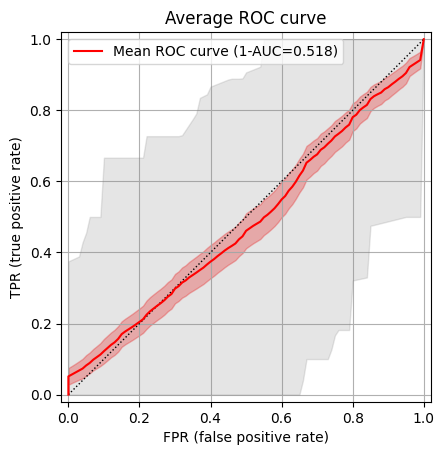

In [826]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.utils import resample
!pip3 install roc_utils
import roc_utils as ru
import warnings
warnings.filterwarnings("ignore") 

# Generating 100 models and predicting 100 test sets using bootstrapping:
rocs = []
n_iterations = 100
for i in range(n_iterations):
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify = y, random_state=i)

    # Scaling the data
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Resampling
    Xtr_bs, ytr_bs = resample(X_train_scaled, y_train, replace=True, random_state=i) 
    Xts_bs, yts_bs = resample(X_test_scaled, y_test, replace=True, random_state=i) 
    
    # Asjusting the model to a training dataset
    model = KNeighborsClassifier(algorithm='auto', n_neighbors=50, weights='uniform')
    model.fit(Xtr_bs, ytr_bs) 
    
    # Predictions
    y_hat = model.predict(Xts_bs)
    
    # Model evaluation ROC plots
    y_prob = model.predict_proba(Xts_bs)
    roc = ru.compute_roc(X=y_prob[:,1], y=yts_bs, pos_label=True)
    rocs.append(roc)
       

ru.plot_mean_roc(rocs, show_ci=True)
plt.title("Average ROC curve");

#####**Confusion matrix**

Text(0.5, 427.9555555555555, 'Predicted label')

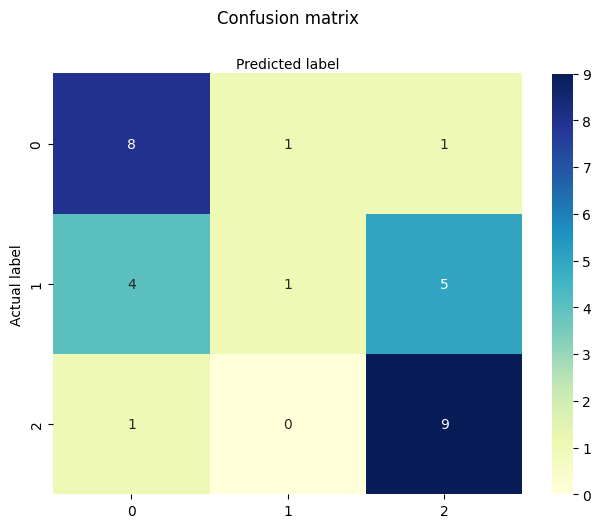

In [827]:
#Testing Logistic regression
model = KNeighborsClassifier(algorithm='auto', n_neighbors=50, weights='uniform')
import warnings
warnings.filterwarnings("ignore") 

# fit the model with data
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Training and testing error:

In [828]:
model = KNeighborsClassifier(algorithm='auto', n_neighbors=50, weights='uniform')
# create and train your model

model.fit(X_train, y_train)

# make predictions on the training set
y_train_pred = model.predict(X_train)

# calculate the mean squared error of the training set predictions
train_error = mean_squared_error(y_train, y_train_pred)

# make predictions on the testing set
y_test_pred = model.predict(X_test)

# calculate the mean squared error of the testing set predictions
test_error = mean_squared_error(y_test, y_test_pred)

# print out the training and testing errors
print("Training Error: ", train_error)
print("Testing Error: ", test_error)

Training Error:  0.9915254237288136
Testing Error:  0.6


Using cross-validation, we obtained a result of 0.4538 for Knn classifier These values are similar to the previous accuracy levels.

##### **Evaluation metrics using K-cross validation**

Next we have the evaluation metrics of one train-test split:

In [829]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore") 

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
X = dataAP_cat.drop(target, axis=1).values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your model
model =  KNeighborsClassifier(algorithm='auto', n_neighbors=50, weights='uniform')
model = model.fit(X_train,y_train)

# Make predictions on the test data
predicted_labels = model.predict(X_test)

# EVALUATION METRICS

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)

# Calculate precision
precision = precision_score(y_test, predicted_labels, average='macro')

# Calculate recall
recall = recall_score(y_test, predicted_labels, average='macro')

# Calculate F1-score
f1 = f1_score(y_test, predicted_labels, average='macro')

# Print the evaluation metrics
print("The evaluation metrics of", model, "are:")
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)


The evaluation metrics of KNeighborsClassifier(n_neighbors=50) are:
Accuracy: 0.5333333333333333
Precision: 0.6041666666666666
Recall: 0.5410774410774412
F1-score: 0.5330718954248366


**Here we have the evaluation metrics using k-cross validation**

In [830]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore") 

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
X = dataAP_cat.drop(target, axis=1).values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your model
model =  KNeighborsClassifier(algorithm='auto', n_neighbors=50, weights='uniform')
model = model.fit(X_train,y_train)

# Initialize the k-fold cross-validation object
k = 10  # Define the number of folds
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store the evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test data
    predicted_labels = model.predict(X_test)

    # Calculate evaluation metrics for the current fold
    accuracy_scores.append(accuracy_score(y_test, predicted_labels))
    precision_scores.append(precision_score(y_test, predicted_labels, average='macro'))
    recall_scores.append(recall_score(y_test, predicted_labels, average='macro'))
    f1_scores.append(f1_score(y_test, predicted_labels, average='macro'))

# Print the average evaluation metrics
print("The average evaluation metrics are:")
print('Accuracy:', sum(accuracy_scores) / k)
print('Precision:', sum(precision_scores) / k)
print('Recall:', sum(recall_scores) / k)
print('F1-score:', sum(f1_scores) / k)

The average evaluation metrics are:
Accuracy: 0.488095238095238
Precision: 0.5161820586820587
Recall: 0.4844444444444444
F1-score: 0.4565020165020165


## DataPHY

- dataPHY: dataframe that contains only physiological data of interest to study the relevance of it.

### Using Grid Search to find the best model and hyper parameter tuning

The models whose best hyperparameters we want to find are the following:
- Logistic Regression
- K-Nearest Neighbours
- Support Vector Machines
- Naïve Bayes
- Decision Tree Classification
- Random Forest Classification

First we define each model and their corresponding possible parameters:

In [831]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


#Define a simple Python dictionary and let's try the models stated before. (LR, KNn, SVM, Kernel SVM, NB, DTC, RFC)

model_params = {
     'logistic_regression' : {
         'model': LogisticRegression(),
         'params': {
             'solver': ['liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
             'C': [1,5,10,20],
             'penalty' : ['l1', 'l2', 'elasticnet'],
         }
     },
     'Knn': {
        'model': KNeighborsClassifier(),
        'params' : {
            'n_neighbors': [5,10,20,50],
            'weights' : ['uniform', 'distance'],
            'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],

        }
    },
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [5,10,20],
            'kernel': ['rbf','linear'],
        }
    },
    
    'Naive_Bayes': {
        'model': GaussianNB(),
        'params' : {
            'var_smoothing' : [1e-09,1e-12,1e-06],
            
        }
    },
    
    'Decision_tree': {
        'model': DecisionTreeClassifier(),
        'params' : {
            'criterion' : ['gini', 'entropy', 'log_loss'],
            'max_depth' : [0.5,3,4,5,15,20],

        }
    },
     'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'criterion' : ['gini', 'entropy', 'log_loss'],
            'n_estimators': [1,5,10],
        }
    }
}

Next we will evaluate these models using GridSearchCV from Sklearn to find the score of each of the models and their best combinations for their parameters.

In [832]:
target = dataAP_cat["Masa_VAT_cat"]
data_target = dataPHY.copy()
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore") 

scores = []

#The following for loop is doing nothing but going throught the dictionary previously defined and for each of the value in the dictionary it will apply the GridSearchCV
for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(data_target, target)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,logistic_regression,0.521609,"{'C': 5, 'penalty': 'l2', 'solver': 'newton-ch..."
1,Knn,0.459540,"{'algorithm': 'auto', 'n_neighbors': 10, 'weig..."
2,svm,0.481379,"{'C': 5, 'kernel': 'linear'}"
3,Naive_Bayes,0.440460,{'var_smoothing': 1e-09}
4,Decision_tree,0.454023,"{'criterion': 'gini', 'max_depth': 3}"
5,random_forest,0.465747,"{'criterion': 'gini', 'n_estimators': 5}"


The best results are from the following models:
- Logistic regression classifier 
- Support Vector machine classifier
- Knn classifier

To choose one of these models first we have to validate them.

In [833]:
#FIRST
#We divide the data between train and testing data:

from sklearn import datasets, linear_model

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
X = dataPHY.values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

AUTOMATIC WAY TO MEASURE ACCURACIES:

In [834]:
#BEST MODELS ACCURACY

#Accuracy score of decision tree classifier, we import accuracy_score from sklearn
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore") 

#Defining the model with the best parameters found with Grid Search.

LR = LogisticRegression(solver='newton-cholesky', C = 5, penalty = 'l2')
SVM = svm.SVC(gamma='auto', C = 5, kernel = 'linear')
KNN =  KNeighborsClassifier(algorithm = 'auto', n_neighbors= 10, weights= 'uniform')

accuracy = {'model': [], 'Accuracy': []}
df = pd.DataFrame(accuracy)

CLF = (LR, SVM , KNN)
for x in CLF:
  clf = x
  clf = clf.fit(X_train, y_train)

  yhat_test = clf.predict(X_test)
  
  acc = accuracy_score(y_test, yhat_test)
  print(acc)

  accdf = {'model': [x], 'Accuracy': [acc]}
  df_acc = pd.DataFrame(accdf)
  df = df.append(df_acc)
df

0.6666666666666666
0.6666666666666666
0.6333333333333333


,model,Accuracy
0,"LogisticRegression(C=5, solver='newton-cholesky')",0.666667
0,"SVC(C=5, gamma='auto', kernel='linear')",0.666667
0,KNeighborsClassifier(n_neighbors=10),0.633333


###Logistic regression

We define the model:

In [835]:
#FIRST
#We divide the data between train and testing data:

from sklearn.feature_selection import SelectFwe, chi2
from sklearn import datasets, linear_model
from sklearn.feature_selection import SelectPercentile, chi2

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
X = dataPHY.values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(solver='newton-cholesky', C = 5, penalty = 'l2')
#RandomForestClassifier(SelectFwe(SelectPercentile("input_matrix", percentile=73), alpha=0.025), bootstrap=True, criterion="entropy", max_features=0.3, min_samples_leaf=4, min_samples_split=17, n_estimators=100)
# 
clf = clf.fit(X_train,y_train.ravel())

##### **Mean ROC curve**

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


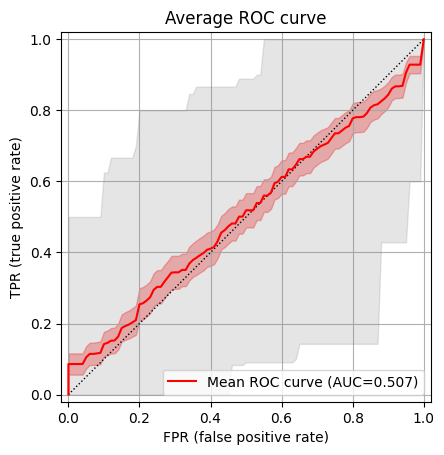

In [836]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.utils import resample
!pip3 install roc_utils
import roc_utils as ru
import warnings
warnings.filterwarnings("ignore") 

# Generating 100 models and predicting 100 test sets using bootstrapping:
rocs = []
n_iterations = 100
for i in range(n_iterations):
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify = y, random_state=i)

    # Scaling the data
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Resampling
    Xtr_bs, ytr_bs = resample(X_train_scaled, y_train, replace=True, random_state=i) 
    Xts_bs, yts_bs = resample(X_test_scaled, y_test, replace=True, random_state=i) 
    
    # Asjusting the model to a training dataset
    model = LogisticRegression(solver='newton-cholesky', C = 5, penalty = 'l2')
    model.fit(Xtr_bs, ytr_bs) 
    
    # Predictions
    y_hat = model.predict(Xts_bs)
    
    # Model evaluation ROC plots
    y_prob = model.predict_proba(Xts_bs)
    roc = ru.compute_roc(X=y_prob[:,1], y=yts_bs, pos_label=True)
    rocs.append(roc)
       

ru.plot_mean_roc(rocs, show_ci=True)
plt.title("Average ROC curve");

#####Confusion matrix

Text(0.5, 427.9555555555555, 'Predicted label')

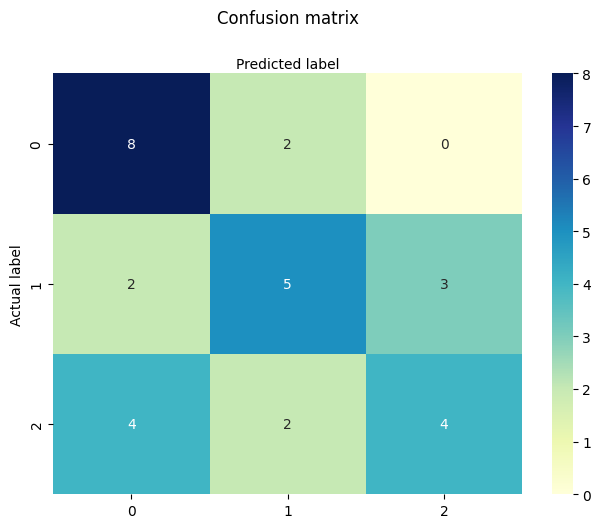

In [837]:
#Testing Logistic regression
Lregr = LogisticRegression(solver='newton-cholesky', C = 5, penalty = 'l2')

# fit the model with data
Lregr.fit(X_train, y_train)
y_pred = Lregr.predict(X_test)

# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Training and testing error:

In [838]:
model = LogisticRegression(solver='newton-cholesky', C = 5, penalty = 'l2')
# create and train your model

model.fit(X_train, y_train)

# make predictions on the training set
y_train_pred = model.predict(X_train)

# calculate the mean squared error of the training set predictions
train_error = mean_squared_error(y_train, y_train_pred)

# make predictions on the testing set
y_test_pred = model.predict(X_test)

# calculate the mean squared error of the testing set predictions
test_error = mean_squared_error(y_test, y_test_pred)

# print out the training and testing errors
print("Training Error: ", train_error)
print("Testing Error: ", test_error)

Training Error:  0.559322033898305
Testing Error:  0.8333333333333334


##### **Evaluation metrics using K-cross validation**

Next we have the evaluation metrics of one train-test split:

In [839]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore") 

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
X = dataPHY.values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your model
model = LogisticRegression(solver='newton-cholesky', C = 5, penalty = 'l2')
model = model.fit(X_train,y_train)

# Make predictions on the test data
predicted_labels = model.predict(X_test)

# EVALUATION METRICS

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)

# Calculate precision
precision = precision_score(y_test, predicted_labels, average='macro')

# Calculate recall
recall = recall_score(y_test, predicted_labels, average='macro')

# Calculate F1-score
f1 = f1_score(y_test, predicted_labels, average='macro')

# Print the evaluation metrics
print("The evaluation metrics of", model, "are:")
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)


The evaluation metrics of LogisticRegression(C=5, solver='newton-cholesky') are:
Accuracy: 0.6666666666666666
Precision: 0.6698412698412698
Recall: 0.6653198653198653
F1-score: 0.652280701754386


**Here we have the evaluation metrics using k-cross validation**

In [840]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore") 

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
X = dataPHY.values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train your model
model = LogisticRegression(solver='newton-cholesky', C = 5, penalty = 'l2')
model = model.fit(X_train,y_train)

# Initialize the k-fold cross-validation object
k = 10  # Define the number of folds
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store the evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test data
    predicted_labels = model.predict(X_test)

    # Calculate evaluation metrics for the current fold
    accuracy_scores.append(accuracy_score(y_test, predicted_labels))
    precision_scores.append(precision_score(y_test, predicted_labels, average='macro'))
    recall_scores.append(recall_score(y_test, predicted_labels, average='macro'))
    f1_scores.append(f1_score(y_test, predicted_labels, average='macro'))

# Print the average evaluation metrics
print("The average evaluation metrics are:")
print('Accuracy:', sum(accuracy_scores) / k)
print('Precision:', sum(precision_scores) / k)
print('Recall:', sum(recall_scores) / k)
print('F1-score:', sum(f1_scores) / k)

The average evaluation metrics are:
Accuracy: 0.4995238095238094
Precision: 0.5058068783068782
Recall: 0.49944444444444436
F1-score: 0.48069541569541574


###Support Vector Machine

We define the model:

In [841]:
#FIRST
#We divide the data between train and testing data:

from sklearn.feature_selection import SelectFwe, chi2
from sklearn import datasets, linear_model
from sklearn.feature_selection import SelectPercentile, chi2

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
X = dataPHY.values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = svm.SVC(gamma='auto', C=10, kernel='linear')
clf = clf.fit(X_train,y_train.ravel())

##### **Mean ROC curve**

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


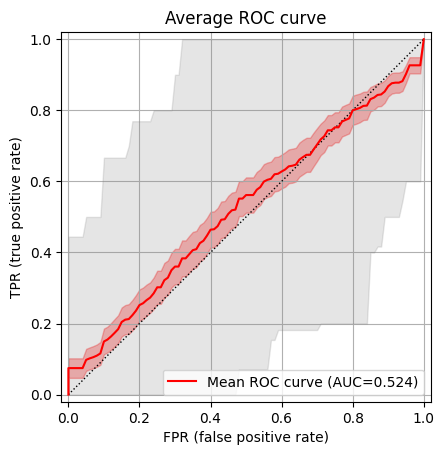

In [842]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.utils import resample
!pip3 install roc_utils
import roc_utils as ru
import warnings
warnings.filterwarnings("ignore") 

# Generating 100 models and predicting 100 test sets using bootstrapping:
rocs = []
n_iterations = 100
for i in range(n_iterations):
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify = y, random_state=i)

    # Scaling the data
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Resampling
    Xtr_bs, ytr_bs = resample(X_train_scaled, y_train, replace=True, random_state=i) 
    Xts_bs, yts_bs = resample(X_test_scaled, y_test, replace=True, random_state=i) 
    
    # Asjusting the model to a training dataset
    model =  svm.SVC(gamma='auto', C=10, kernel='linear', probability =True)
    model.fit(Xtr_bs, ytr_bs) 

    # Predictions
    y_hat = model.predict(Xts_bs)
    
    # Model evaluation ROC plots
    y_prob = model.predict_proba(Xts_bs)
    roc = ru.compute_roc(X=y_prob[:,1], y=yts_bs, pos_label=True)
    rocs.append(roc)
       

ru.plot_mean_roc(rocs, show_ci=True)
plt.title("Average ROC curve");

#####Confusion matrix

Text(0.5, 427.9555555555555, 'Predicted label')

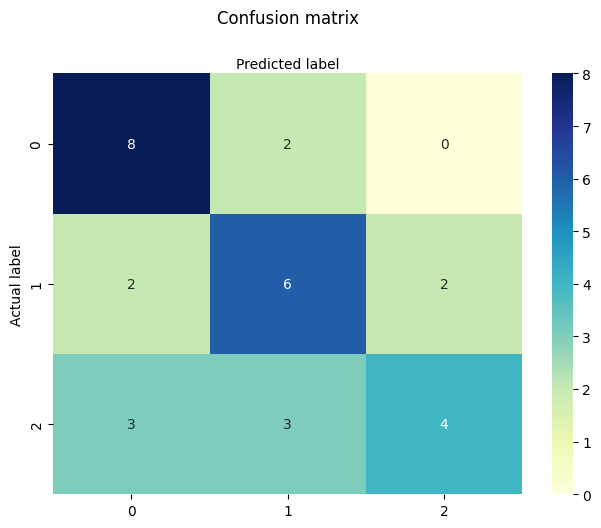

In [843]:
#Testing SVM
model =svm.SVC(gamma='auto', C = 5, kernel = 'linear')

# fit the model with data
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Training and testing error:

In [844]:
model = svm.SVC(gamma='auto', C = 5, kernel = 'linear')

# create and train your model

model.fit(X_train, y_train)

# make predictions on the training set
y_train_pred = model.predict(X_train)

# calculate the mean squared error of the training set predictions
train_error = mean_squared_error(y_train, y_train_pred)

# make predictions on the testing set
y_test_pred = model.predict(X_test)

# calculate the mean squared error of the testing set predictions
test_error = mean_squared_error(y_test, y_test_pred)

# print out the training and testing errors
print("Training Error: ", train_error)
print("Testing Error: ", test_error)
import warnings
warnings.filterwarnings("ignore") 

Training Error:  0.5677966101694916
Testing Error:  0.7


##### **Evaluation metrics using K-cross validation**

Next we have the evaluation metrics of one train-test split:

In [845]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore") 

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
X = dataPHY.values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your model
model = svm.SVC(gamma='auto', C = 5, kernel = 'linear')
model = model.fit(X_train,y_train)

# Make predictions on the test data
predicted_labels = model.predict(X_test)

# EVALUATION METRICS

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)

# Calculate precision
precision = precision_score(y_test, predicted_labels, average='macro')

# Calculate recall
recall = recall_score(y_test, predicted_labels, average='macro')

# Calculate F1-score
f1 = f1_score(y_test, predicted_labels, average='macro')

# Print the evaluation metrics
print("The evaluation metrics of", model, "are:")
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)


The evaluation metrics of SVC(C=5, gamma='auto', kernel='linear') are:
Accuracy: 0.6666666666666666
Precision: 0.7013888888888888
Recall: 0.6653198653198653
F1-score: 0.6633986928104575


**Here we have the evaluation metrics using k-cross validation**

In [846]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore") 

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
X = dataPHY.values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your model
model = svm.SVC(gamma='auto', C = 5, kernel = 'linear')
model = model.fit(X_train,y_train)

# Initialize the k-fold cross-validation object
k = 10  # Define the number of folds
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store the evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test data
    predicted_labels = model.predict(X_test)

    # Calculate evaluation metrics for the current fold
    accuracy_scores.append(accuracy_score(y_test, predicted_labels))
    precision_scores.append(precision_score(y_test, predicted_labels, average='macro'))
    recall_scores.append(recall_score(y_test, predicted_labels, average='macro'))
    f1_scores.append(f1_score(y_test, predicted_labels, average='macro'))

# Print the average evaluation metrics
print("The average evaluation metrics are:")
print('Accuracy:', sum(accuracy_scores) / k)
print('Precision:', sum(precision_scores) / k)
print('Recall:', sum(recall_scores) / k)
print('F1-score:', sum(f1_scores) / k)

The average evaluation metrics are:
Accuracy: 0.4861904761904762
Precision: 0.5048280423280423
Recall: 0.48611111111111105
F1-score: 0.4703169053169053


###K-nearest neighbors 

We define the model:

In [847]:
#FIRST
#We divide the data between train and testing data:

from sklearn.feature_selection import SelectFwe, chi2
from sklearn import datasets, linear_model
from sklearn.feature_selection import SelectPercentile, chi2

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
X = dataPHY.values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf =  KNeighborsClassifier(algorithm = 'auto', n_neighbors= 10, weights= 'uniform')
#RandomForestClassifier(SelectFwe(SelectPercentile("input_matrix", percentile=73), alpha=0.025), bootstrap=True, criterion="entropy", max_features=0.3, min_samples_leaf=4, min_samples_split=17, n_estimators=100)
# 
clf = clf.fit(X_train,y_train.ravel())

##### **Mean ROC curve**

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


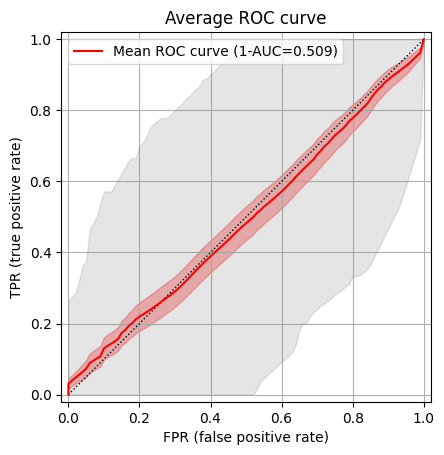

In [848]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.utils import resample
!pip3 install roc_utils
import roc_utils as ru
import warnings
warnings.filterwarnings("ignore") 

# Generating 100 models and predicting 100 test sets using bootstrapping:
rocs = []
n_iterations = 100
for i in range(n_iterations):
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify = y, random_state=i)

    # Scaling the data
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Resampling
    Xtr_bs, ytr_bs = resample(X_train_scaled, y_train, replace=True, random_state=i) 
    Xts_bs, yts_bs = resample(X_test_scaled, y_test, replace=True, random_state=i) 
    
    # Asjusting the model to a training dataset
    model = KNeighborsClassifier(algorithm = 'auto', n_neighbors= 10, weights= 'uniform')
    model.fit(Xtr_bs, ytr_bs) 
    
    
    # Predictions
    y_hat = model.predict(Xts_bs)
    
    # Model evaluation ROC plots
    y_prob = model.predict_proba(Xts_bs)
    roc = ru.compute_roc(X=y_prob[:,1], y=yts_bs, pos_label=True)
    rocs.append(roc)
       

ru.plot_mean_roc(rocs, show_ci=True)
plt.title("Average ROC curve");

#####Confusion matrix

Text(0.5, 427.9555555555555, 'Predicted label')

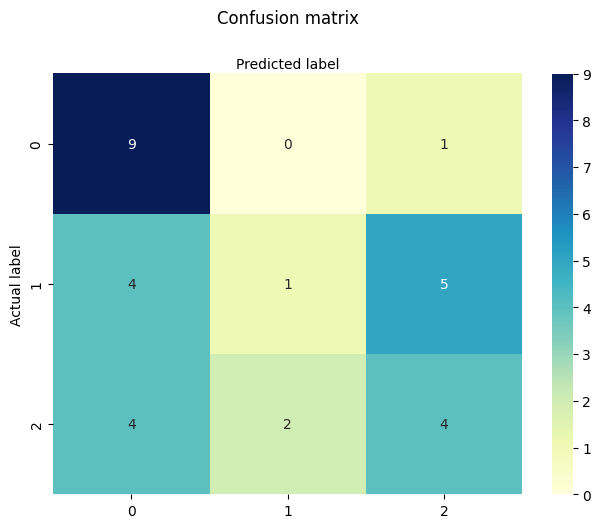

In [849]:
#Testing Logistic regression
model = KNeighborsClassifier(algorithm = 'auto', n_neighbors= 10, weights= 'uniform')

# fit the model with data
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Training and testing error:

In [850]:
model = KNeighborsClassifier(algorithm = 'auto', n_neighbors= 10, weights= 'uniform')

# create and train your model

model.fit(X_train, y_train)

# make predictions on the training set
y_train_pred = model.predict(X_train)

# calculate the mean squared error of the training set predictions
train_error = mean_squared_error(y_train, y_train_pred)

# make predictions on the testing set
y_test_pred = model.predict(X_test)

# calculate the mean squared error of the testing set predictions
test_error = mean_squared_error(y_test, y_test_pred)

# print out the training and testing errors
print("Training Error: ", train_error)
print("Testing Error: ", test_error)

Training Error:  0.8135593220338984
Testing Error:  1.0333333333333334


##### **Evaluation metrics using K-cross validation**

Next we have the evaluation metrics of one train-test split:

In [851]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore") 

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
X = dataPHY.values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your model
model =KNeighborsClassifier(algorithm = 'auto', n_neighbors= 10, weights= 'uniform')
model = model.fit(X_train,y_train)

# Make predictions on the test data
predicted_labels = model.predict(X_test)

# EVALUATION METRICS

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)

# Calculate precision
precision = precision_score(y_test, predicted_labels, average='macro')

# Calculate recall
recall = recall_score(y_test, predicted_labels, average='macro')

# Calculate F1-score
f1 = f1_score(y_test, predicted_labels, average='macro')

# Print the evaluation metrics
print("The evaluation metrics of", model, "are:")
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)


The evaluation metrics of KNeighborsClassifier(n_neighbors=10) are:
Accuracy: 0.6333333333333333
Precision: 0.6444444444444444
Recall: 0.6356902356902357
F1-score: 0.5873015873015873


**Here we have the evaluation metrics using k-cross validation**

In [852]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore") 


#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
X = dataPHY.values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your model
model =KNeighborsClassifier(algorithm = 'auto', n_neighbors= 10, weights= 'uniform')
model = model.fit(X_train,y_train)

# Make predictions on the test data
predicted_labels = model.predict(X_test)
# Initialize the k-fold cross-validation object
k = 10  # Define the number of folds
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store the evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test data
    predicted_labels = model.predict(X_test)

    # Calculate evaluation metrics for the current fold
    accuracy_scores.append(accuracy_score(y_test, predicted_labels))
    precision_scores.append(precision_score(y_test, predicted_labels, average='macro'))
    recall_scores.append(recall_score(y_test, predicted_labels, average='macro'))
    f1_scores.append(f1_score(y_test, predicted_labels, average='macro'))

# Print the average evaluation metrics
print("The average evaluation metrics are:")
print('Accuracy:', sum(accuracy_scores) / k)
print('Precision:', sum(precision_scores) / k)
print('Recall:', sum(recall_scores) / k)
print('F1-score:', sum(f1_scores) / k)

The average evaluation metrics are:
Accuracy: 0.4723809523809524
Precision: 0.44839105339105334
Recall: 0.4738888888888889
F1-score: 0.42598383098383097


## DataALL

- dataALL: dataframe that contains both dataAP and dataPHY.

### Using Grid Search to find the best model and hyper parameter tuning

The models whose best hyperparameters we want to find are the following:
- Logistic Regression
- K-Nearest Neighbours
- Support Vector Machines
- Naïve Bayes
- Decision Tree Classification
- Random Forest Classification

First we define each model and their corresponding possible parameters:

In [853]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


#Define a simple Python dictionary and let's try the models stated before. (LR, KNn, SVM, Kernel SVM, NB, DTC, RFC)

model_params = {
     'logistic_regression' : {
         'model': LogisticRegression(),
         'params': {
             'solver': ['liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
             'C': [1,5,10,20],
             'penalty' : ['l1', 'l2', 'elasticnet'],
         }
     },
     'Knn': {
        'model': KNeighborsClassifier(),
        'params' : {
            'n_neighbors': [5,10,20,50],
            'weights' : ['uniform', 'distance'],
            'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],

        }
    },
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [5,10,20],
            'kernel': ['rbf','linear'],
        }
    },
    
    'Naive_Bayes': {
        'model': GaussianNB(),
        'params' : {
            'var_smoothing' : [1e-09,1e-12,1e-06],
            
        }
    },
    
    'Decision_tree': {
        'model': DecisionTreeClassifier(),
        'params' : {
            'criterion' : ['gini', 'entropy', 'log_loss'],
            'max_depth' : [0.5,3,4,5,15,20],

        }
    },
     'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'criterion' : ['gini', 'entropy', 'log_loss'],
            'n_estimators': [1,5,10],
        }
    }
}

Next we will evaluate these models using GridSearchCV from Sklearn to find the score of each of the models and their best combinations for their parameters.

In [854]:
target = dataALL["Masa_VAT_cat"]
drop = ["Masa_VAT_g", "Vol_VAT", "Masa_VAT_cat"]
data_target = dataALL.copy()
data_target = data_target.drop(drop, axis=1)

from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore") 

scores = []

#The following for loop is doing nothing but going throught the dictionary previously defined and for each of the value in the dictionary it will apply the GridSearchCV
for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(data_target, target)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,logistic_regression,0.630115,"{'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}"
1,Knn,0.540460,"{'algorithm': 'auto', 'n_neighbors': 10, 'weig..."
2,svm,0.623448,"{'C': 20, 'kernel': 'linear'}"
3,Naive_Bayes,0.555402,{'var_smoothing': 1e-09}
4,Decision_tree,0.479770,"{'criterion': 'gini', 'max_depth': 3}"
5,random_forest,0.479770,"{'criterion': 'entropy', 'n_estimators': 10}"


The best results are from the following models:
- Logistic regression classifier 
- Support Vector machine classifier
- Naive_Bayes classifier

To choose one of these models first we have to validate them.

In [855]:
#FIRST
#We divide the data between train and testing data:

from sklearn import datasets, linear_model

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
drop=["Masa_VAT_cat", "Masa_VAT_g", "Vol_VAT"]
X = dataALL.drop(drop, axis=1).values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

AUTOMATIC WAY TO MEASURE ACCURACIES:

In [856]:
#BEST MODELS ACCURACY

#Accuracy score of decision tree classifier, we import accuracy_score from sklearn
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore") 

#Defining the model with the best parameters found with Grid Search.

LR = LogisticRegression(solver='newton-cg', C = 10, penalty = 'l2')
SVM = svm.SVC(gamma='auto', C = 20, kernel = 'linear')
NB = GaussianNB(var_smoothing = 1e-09)

accuracy = {'model': [], 'Accuracy': []}
df = pd.DataFrame(accuracy)

CLF = (LR, SVM , NB)
for x in CLF:
  clf = x
  clf = clf.fit(X_train, y_train)

  yhat_test = clf.predict(X_test)
  
  acc = accuracy_score(y_test, yhat_test)
  print(acc)

  accdf = {'model': [x], 'Accuracy': [acc]}
  df_acc = pd.DataFrame(accdf)
  df = df.append(df_acc)
df

0.6333333333333333
0.7333333333333333
0.6


,model,Accuracy
0,"LogisticRegression(C=10, solver='newton-cg')",0.633333
0,"SVC(C=20, gamma='auto', kernel='linear')",0.733333
0,GaussianNB(),0.600000


###Logistic regression

We define the model:

In [857]:
#FIRST
#We divide the data between train and testing data:

from sklearn.feature_selection import SelectFwe, chi2
from sklearn import datasets, linear_model
from sklearn.feature_selection import SelectPercentile, chi2

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
drop=["Masa_VAT_cat", "Masa_VAT_g", "Vol_VAT"]
X = dataALL.drop(drop, axis=1).values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LogisticRegression(solver='newton-cg', C = 10, penalty = 'l2')
#RandomForestClassifier(SelectFwe(SelectPercentile("input_matrix", percentile=73), alpha=0.025), bootstrap=True, criterion="entropy", max_features=0.3, min_samples_leaf=4, min_samples_split=17, n_estimators=100)
# 
clf = clf.fit(X_train,y_train.ravel())

##### **Mean ROC curve**

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


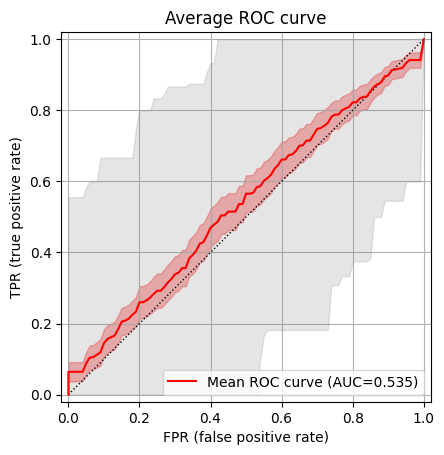

In [858]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.utils import resample
!pip3 install roc_utils
import roc_utils as ru
import warnings
warnings.filterwarnings("ignore") 

# Generating 100 models and predicting 100 test sets using bootstrapping:
rocs = []
n_iterations = 100
for i in range(n_iterations):
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify = y, random_state=i)

    # Scaling the data
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Resampling
    Xtr_bs, ytr_bs = resample(X_train_scaled, y_train, replace=True, random_state=i) 
    Xts_bs, yts_bs = resample(X_test_scaled, y_test, replace=True, random_state=i) 
    
    # Fitting the model to the training dataset
    model = LogisticRegression(solver='newton-cg', C = 10, penalty = 'l2')
    model.fit(Xtr_bs, ytr_bs) 
    
    
    # Predictions
    y_hat = model.predict(Xts_bs)
    
    # Model evaluation ROC plots
    y_prob = model.predict_proba(Xts_bs)
    roc = ru.compute_roc(X=y_prob[:,1], y=yts_bs, pos_label=True)
    rocs.append(roc)
       

ru.plot_mean_roc(rocs, show_ci=True)
plt.title("Average ROC curve");

#####Confusion matrix

Text(0.5, 427.9555555555555, 'Predicted label')

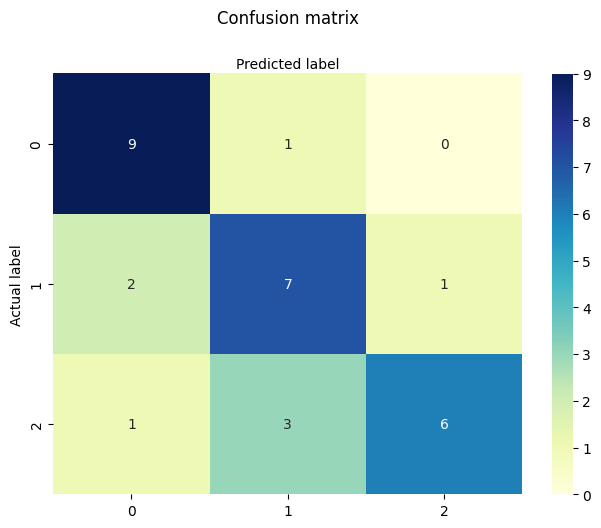

In [859]:
#Testing Logistic regression
Lregr = LogisticRegression(solver='newton-cg', C = 10, penalty = 'l2')

# fit the model with data
Lregr.fit(X_train, y_train)
y_pred = Lregr.predict(X_test)

# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Training and testing error:

In [860]:
model = LogisticRegression(solver='newton-cg', C = 10, penalty = 'l2')
# create and train your model

model.fit(X_train, y_train)

# make predictions on the training set
y_train_pred = model.predict(X_train)

# calculate the mean squared error of the training set predictions
train_error = mean_squared_error(y_train, y_train_pred)

# make predictions on the testing set
y_test_pred = model.predict(X_test)

# calculate the mean squared error of the testing set predictions
test_error = mean_squared_error(y_test, y_test_pred)

# print out the training and testing errors
print("Training Error: ", train_error)
print("Testing Error: ", test_error)
import warnings
warnings.filterwarnings("ignore") 

Training Error:  0.3135593220338983
Testing Error:  0.36666666666666664


##### **Evaluation metrics using K-cross validation**

Next we have the evaluation metrics of one train-test split:

In [861]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore") 

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
drop=["Masa_VAT_cat", "Masa_VAT_g", "Vol_VAT"]
X = dataALL.drop(drop, axis=1).values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your model
model = LogisticRegression(solver='newton-cholesky', C = 5, penalty = 'l2')
model = model.fit(X_train,y_train)

# Make predictions on the test data
predicted_labels = model.predict(X_test)

# EVALUATION METRICS

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)

# Calculate precision
precision = precision_score(y_test, predicted_labels, average='macro')

# Calculate recall
recall = recall_score(y_test, predicted_labels, average='macro')

# Calculate F1-score
f1 = f1_score(y_test, predicted_labels, average='macro')

# Print the evaluation metrics
print("The evaluation metrics of", model, "are:")
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)


The evaluation metrics of LogisticRegression(C=5, solver='newton-cholesky') are:
Accuracy: 0.6666666666666666
Precision: 0.7227668845315903
Recall: 0.6757575757575758
F1-score: 0.6402930402930402


**Here we have the evaluation metrics using k-cross validation**

In [862]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore") 


#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
drop=["Masa_VAT_cat", "Masa_VAT_g", "Vol_VAT"]
X = dataALL.drop(drop, axis=1).values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train your model
model = LogisticRegression(solver='newton-cholesky', C = 5, penalty = 'l2')
model = model.fit(X_train,y_train)

# Make predictions on the test data
predicted_labels = model.predict(X_test)
# Initialize the k-fold cross-validation object
k = 10  # Define the number of folds
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store the evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test data
    predicted_labels = model.predict(X_test)

    # Calculate evaluation metrics for the current fold
    accuracy_scores.append(accuracy_score(y_test, predicted_labels))
    precision_scores.append(precision_score(y_test, predicted_labels, average='macro'))
    recall_scores.append(recall_score(y_test, predicted_labels, average='macro'))
    f1_scores.append(f1_score(y_test, predicted_labels, average='macro'))

# Print the average evaluation metrics
print("The average evaluation metrics are:")
print('Accuracy:', sum(accuracy_scores) / k)
print('Precision:', sum(precision_scores) / k)
print('Recall:', sum(recall_scores) / k)
print('F1-score:', sum(f1_scores) / k)

The average evaluation metrics are:
Accuracy: 0.569047619047619
Precision: 0.5976190476190475
Recall: 0.5672222222222223
F1-score: 0.5475265475265475


###Support Vector Machine

We define the model:

In [863]:
#FIRST
#We divide the data between train and testing data:

from sklearn.feature_selection import SelectFwe, chi2
from sklearn import datasets, linear_model
from sklearn.feature_selection import SelectPercentile, chi2

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
drop=["Masa_VAT_cat", "Masa_VAT_g", "Vol_VAT"]
X = dataALL.drop(drop, axis=1).values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = svm.SVC(gamma='auto', C = 20, kernel = 'linear')
clf = clf.fit(X_train,y_train.ravel())

##### **Mean ROC curve**

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


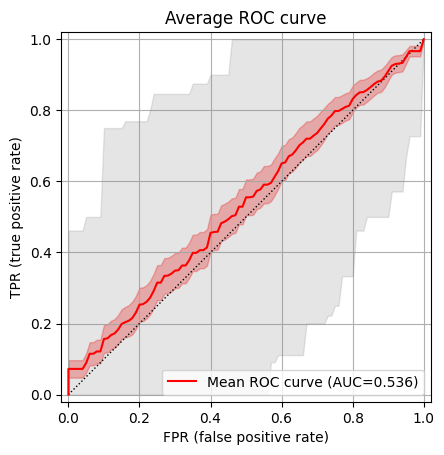

In [864]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.utils import resample
!pip3 install roc_utils
import roc_utils as ru
import warnings
warnings.filterwarnings("ignore") 

# Generating 100 models and predicting 100 test sets using bootstrapping:
rocs = []
n_iterations = 100
for i in range(n_iterations):
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify = y, random_state=i)

    # Scaling the data
    scaler = preprocessing.StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Resampling
    Xtr_bs, ytr_bs = resample(X_train_scaled, y_train, replace=True, random_state=i) 
    Xts_bs, yts_bs = resample(X_test_scaled, y_test, replace=True, random_state=i) 
    
    # Fitting the model to the training dataset
    model =  svm.SVC(gamma='auto', C = 20, kernel = 'linear', probability =True)
    model.fit(Xtr_bs, ytr_bs) 
    
    # Predictions
    y_hat = model.predict(Xts_bs)
    
    # Model evaluation ROC plots
    y_prob = model.predict_proba(Xts_bs)
    roc = ru.compute_roc(X=y_prob[:,1], y=yts_bs, pos_label=True)
    rocs.append(roc)
       

ru.plot_mean_roc(rocs, show_ci=True)
plt.title("Average ROC curve");

#####Confusion matrix

Text(0.5, 427.9555555555555, 'Predicted label')

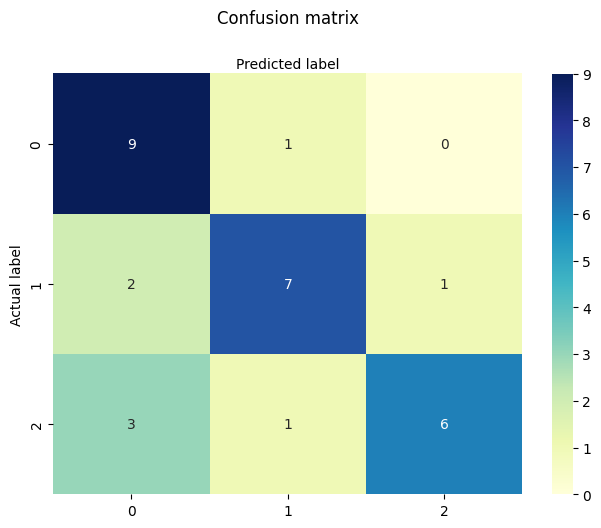

In [865]:
#Testing SVM
model =svm.SVC(gamma='auto', C = 20, kernel = 'linear')

# fit the model with data
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# import the metrics class
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Testing and training error:

In [866]:
model = svm.SVC(gamma='auto', C = 20, kernel = 'linear')
# create and train your model

model.fit(X_train, y_train)

# make predictions on the training set
y_train_pred = model.predict(X_train)

# calculate the mean squared error of the training set predictions
train_error = mean_squared_error(y_train, y_train_pred)

# make predictions on the testing set
y_test_pred = model.predict(X_test)

# calculate the mean squared error of the testing set predictions
test_error = mean_squared_error(y_test, y_test_pred)

# print out the training and testing errors
print("Training Error: ", train_error)
print("Testing Error: ", test_error)
import warnings
warnings.filterwarnings("ignore") 

Training Error:  0.3474576271186441
Testing Error:  0.5666666666666667


##### **Evaluation metrics using K-cross validation**

Next we have the evaluation metrics of one train-test split:

In [867]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore") 

#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
drop=["Masa_VAT_cat", "Masa_VAT_g", "Vol_VAT"]
X = dataALL.drop(drop, axis=1).values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train your model
model = svm.SVC(gamma='auto', C = 20, kernel = 'linear')
model = model.fit(X_train,y_train)

# Make predictions on the test data
predicted_labels = model.predict(X_test)


# EVALUATION METRICS

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted_labels)

# Calculate precision
precision = precision_score(y_test, predicted_labels, average='macro')

# Calculate recall
recall = recall_score(y_test, predicted_labels, average='macro')

# Calculate F1-score
f1 = f1_score(y_test, predicted_labels, average='macro')

# Print the evaluation metrics
print("The evaluation metrics of", model, "are:")
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1-score:', f1)


The evaluation metrics of SVC(C=20, gamma='auto', kernel='linear') are:
Accuracy: 0.7333333333333333
Precision: 0.8111111111111112
Recall: 0.7363636363636363
F1-score: 0.6937012263099219


**Here we have the evaluation metrics using k-cross validation**

In [868]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore") 


#Separating the target variables (Masa_VAT_g and Vol_VAT) from the independent features
target = ["Masa_VAT_cat"]
drop=["Masa_VAT_cat", "Masa_VAT_g", "Vol_VAT"]
X = dataALL.drop(drop, axis=1).values
y = dataAP_cat[target].values	

from sklearn.model_selection import train_test_split

# Splitting the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training the model
model = svm.SVC(gamma='auto', C = 20, kernel = 'linear')
model = model.fit(X_train,y_train)

# Make predictions on the test data
predicted_labels = model.predict(X_test)
# Initialize the k-fold cross-validation object
k = 10  # Define the number of folds
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Lists to store the evaluation metrics for each fold
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

# Perform k-fold cross-validation
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test data
    predicted_labels = model.predict(X_test)

    # Calculate evaluation metrics for the current fold
    accuracy_scores.append(accuracy_score(y_test, predicted_labels))
    precision_scores.append(precision_score(y_test, predicted_labels, average='macro'))
    recall_scores.append(recall_score(y_test, predicted_labels, average='macro'))
    f1_scores.append(f1_score(y_test, predicted_labels, average='macro'))

# Print the average evaluation metrics
print("The average evaluation metrics are:")
print('Accuracy:', sum(accuracy_scores) / k)
print('Precision:', sum(precision_scores) / k)
print('Recall:', sum(recall_scores) / k)
print('F1-score:', sum(f1_scores) / k)

The average evaluation metrics are:
Accuracy: 0.5947619047619048
Precision: 0.6428306878306878
Recall: 0.5922222222222222
F1-score: 0.5847082547082547
